In [1]:
# import lib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import make_moons,make_classification,make_regression,make_circles
import sys
from mpl_toolkits.mplot3d import Axes3D 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA,KernelPCA
np.random.seed(23)
np.set_printoptions(precision=3,suppress=True)
plt.style.use('seaborn')

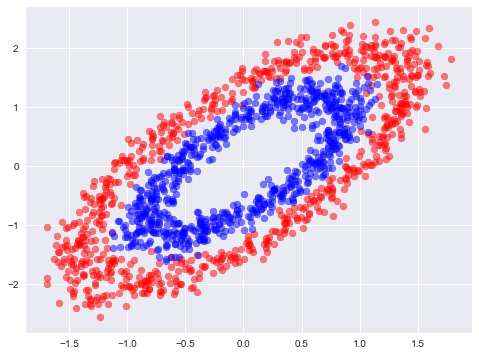

In [5]:
# See the data 
X, y = make_circles(n_samples=1500, factor=.6, noise=.1)
X = X @ np.array([[1,0],[1,2]])
# X,y = make_regression(n_samples=400, n_features=1,noise=5); X = np.concatenate((X,y[:,None]),1) 

# ======== WE ARE CENTERING AND STD =======
# X[:,1] = -X[:,1]
# X = (X - X.mean(0))/X.std(0)
# ======== WE ARE CENTERING AND STD =======

plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.show()

In [8]:
# simple
w = np.random.randn(2,3)

def _sym_decorrelation(W):
    """ Symmetric decorrelation
    i.e. W <- (W * W.T) ^{-1/2} * W
    """
    s, u = np.linalg.eigh(np.dot(W, W.T))
    # u (resp. s) contains the eigenvectors (resp. square roots of
    # the eigenvalues) of W * W.T
    return np.dot(np.dot(u * (1. / np.sqrt(s+1e-8)), u.T), W)
w    = _sym_decorrelation(w)
temp1 = X @ w

# beforew = np.copy(w)
# trace1 = go.Scatter3d(
#     x=temp1[y==0,0],
#     y=temp1[y==0,1],
#     z=temp1[y==0,2],
#     mode='markers',
#     line=dict(color='red',width=0.5),
#     marker=dict(size=3,opacity=0.3)
# )
# trace2 = go.Scatter3d(
#     x=temp1[y==1,0],
#     y=temp1[y==1,1],
#     z=temp1[y==1,2],
#     mode='markers',
#     line=dict(color='blue',width=0.5),
#     marker=dict(size=3,opacity=0.3)
# )
# data = [trace1,trace2]
# fig  = go.Figure(data=data)
# iplot(fig)

for _ in range(100):
    for current_batch_index in range(0,len(X),100):
        x_mini = X[current_batch_index:current_batch_index+100]
        x_mini = x_mini + np.random.normal(size=x_mini.shape)*10
        w = w - 0.000001 * -2 * x_mini.T @ x_mini @ w
        w = _sym_decorrelation(w)
        #print(w)

temp2 = X @ w
trace1 = go.Scatter3d(
    x=temp2[y==0,0],
    y=temp2[y==0,1],
    z=temp2[y==0,2],
    mode='markers',
    line=dict(color='red',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
trace2 = go.Scatter3d(
    x=temp2[y==1,0],
    y=temp2[y==1,1],
    z=temp2[y==1,2],
    mode='markers',
    line=dict(color='blue',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
data = [trace1,trace2]
fig  = go.Figure(data=data)
iplot(fig)

print(beforew)
print(w)

NameError: name 'beforew' is not defined

In [174]:
# simple
w = np.random.randn(2,3)
beforew = np.copy(w)

for _ in range(300):
    for current_batch_index in range(0,len(X),100):
        x_mini  = X[current_batch_index:current_batch_index+100]
        
        cov = w @ w.T
        evalue, evector  = np.linalg.eigh(cov)
        one   = evector * (1./np.sqrt(evalue+1e-8))
        two   = one @ evector.T
        three = two @ w
        
        grad_three  = -2 * x_mini.T @ x_mini @ three
        grad_two    = grad_three @ w.T
        grad_one    = grad_two @ evector
        grad_val    = (evector * grad_one * (-1/2) * (evalue+1e-8) **(-3/2)).mean(0)
        grad_vec    = (one.T @ grad_two).T + grad_one*(1./np.sqrt(evalue+1e-8))
        
        E = np.ones((2,1)) @ evalue[None,:] - evalue[:,None] @ np.ones((1,2))
        F = 1./(E+np.eye(2)) - np.eye(2)
        
        grad_cov = np.linalg.inv(evector).T @ (np.diag(grad_val) + F * (evector.T @ grad_vec)) @ evector.T
        grad_w   = two.T @ grad_three + grad_cov @ w + (w.T @ grad_cov).T
        w = w - 0.000008 * grad_w

after  = X @ w

trace1 = go.Scatter3d(
    x=after[y==0,0],
    y=after[y==0,1],
    z=after[y==0,2],
    mode='markers',
    line=dict(color='red',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
trace2 = go.Scatter3d(
    x=after[y==1,0],
    y=after[y==1,1],
    z=after[y==1,2],
    mode='markers',
    line=dict(color='blue',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
data = [trace1,trace2]
fig  = go.Figure(data=data)
iplot(fig)

print(beforew)
print(_sym_decorrelation(beforew))

print(w)
print(_sym_decorrelation(w))

[[ 0.237 -0.706 -0.075]
 [-0.705  0.119  0.328]]
[[ 0.097 -0.995  0.006]
 [-0.898 -0.085  0.431]]
[[ 1.162 -2.388 -0.425]
 [-2.527  0.789  1.157]]
[[ 0.097 -0.995  0.006]
 [-0.898 -0.085  0.431]]


In [173]:
Sdadsa = (X[:,0] ** 2 + X[:,1] ** 2)[:,None]
sss = np.concatenate([X,Sdadsa],1)

trace1 = go.Scatter3d(
    x=sss[y==0,0],
    y=sss[y==0,1],
    z=sss[y==0,2],
    mode='markers',
    line=dict(color='red',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
trace2 = go.Scatter3d(
    x=sss[y==1,0],
    y=sss[y==1,1],
    z=sss[y==1,2],
    mode='markers',
    line=dict(color='blue',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
data = [trace1,trace2]
fig  = go.Figure(data=data)
iplot(fig)

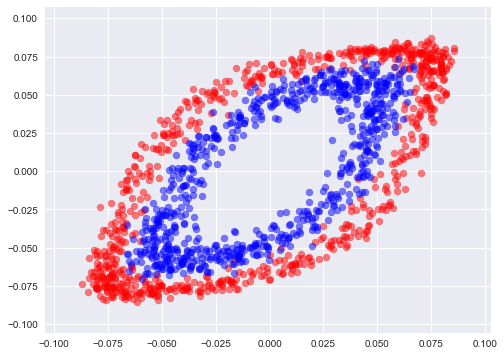

In [215]:
fdsafdsafds = np.arctan(np.array([.5,-.9])*X) 
fdsafdsafds = np.arctan(np.array([-.45,.1])*fdsafdsafds) 
fdsafdsafds = np.arctan(np.array([.25,-.8])*fdsafdsafds) 


plt.figure(figsize=(8,6))
plt.scatter(fdsafdsafds[y==0, 0], fdsafdsafds[y==0, 1], color='red', alpha=0.5)
plt.scatter(fdsafdsafds[y==1, 0], fdsafdsafds[y==1, 1], color='blue', alpha=0.5)
plt.show()

In [222]:
trysss = np.array([
    [1,2,2],
    [-2,1,0]
])
jksafbdskj6 = X@ trysss + np.array([[1,0,3]])
trace1 = go.Scatter3d(
    x=jksafbdskj6[y==0,0],
    y=jksafbdskj6[y==0,1],
    z=jksafbdskj6[y==0,2],
    mode='markers',
    line=dict(color='red',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
trace2 = go.Scatter3d(
    x=jksafbdskj6[y==1,0],
    y=jksafbdskj6[y==1,1],
    z=jksafbdskj6[y==1,2],
    mode='markers',
    line=dict(color='blue',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
data = [trace1,trace2]
fig  = go.Figure(data=data)
iplot(fig)

In [105]:

weight = np.random.randn(3,2)*10 + 8
print(weight.T@weight)

dsadas = _sym_decorrelation(weight)

evalue, evector = np.linalg.eigh(weight@weight.T)
one   = evector * (1. / np.sqrt(evalue+1e-8))
two   = one @ evector.T
three = two @ weight

# print(three)
print(three.T@three)

def _sym_decorrelation(W):
    """ Symmetric decorrelation
    i.e. W <- (W * W.T) ^{-1/2} * W
    """
    s, u = np.linalg.eigh(np.dot(W, W.T))
    # u (resp. s) contains the eigenvectors (resp. square roots of
    # the eigenvalues) of W * W.T
    return np.dot(np.dot(u * (1. / np.sqrt(s+1e-8)), u.T), W)

print(np.allclose(three,dsadas))

[[1124.375  507.427]
 [ 507.427  295.282]]
[[1. 0.]
 [0. 1.]]
True


In [127]:
temp_grad = np.ones_like(temp)

dddd =np.array([[1,-2],[-2,1]])
evalue, evector = np.linalg.eigh(dddd)
print(evalue)
print(evector)

U = evector
D = evalue

E = np.ones((2,1)) @ D[None,:] - D[:,None] @ np.ones((1,2))
F = 1./(E+np.eye(2)) - np.eye(2)

dU = np.ones_like(U)
dD = np.ones_like(D)

DA = np.linalg.inv(evector).T @ (np.diag(dD) + F * (evector.T @ dU)) @ evector.T
print(DA)

[-1.  3.]
[[-0.707 -0.707]
 [-0.707  0.707]]
[[ 0.823  0.177]
 [-0.177  1.177]]


In [11]:
X.mean(0)


array([ 0.001, -0.004])

In [6]:
X.mean(0)
X.std(0)

array([0.839, 1.189])

In [13]:
temp = _sym_decorrelation(X)
print(temp.mean(0))
print(temp.std(0))
print(temp.T@temp)

[ 0. -0.]
[0.026 0.026]
[[1. 0.]
 [0. 1.]]


In [95]:
#  act functions 
def g(x) :     return np.arctan(x)
def gg(x):     return np.tan(x)
def g_grad(x): return 1/(1+x**2)
def gg_grad(x):return 1/(np.cos(x)*2+1e-8)

class PCA_layer():

    def __init__(self,inc,outc,act=g,d_act=g_grad):
        
        self.w =self.sym_decorrelation(np.random.normal(size=(inc,outc)))
        self.a =np.random.normal(0,3,size=(outc))
        self.b =np.random.normal(0,3,size=(outc))
        self.c =np.random.normal(0,5,size=(outc))
        self.act = act; self.d_act = d_act
        
        self.mw,self.vw = np.zeros_like(self.w),np.zeros_like(self.w)
        self.ma,self.va = np.zeros_like(self.a),np.zeros_like(self.a)
        self.mb,self.vb = np.zeros_like(self.b),np.zeros_like(self.b)
        self.mc,self.vc = np.zeros_like(self.c),np.zeros_like(self.c) 
    
    def feed_linear(self,input_value):
        self.input = input_value
        self.layer = self.input @ self.w
        var = self.w.T @ self.input.T @ self.input @ self.w
        return self.layer,var
    def back_linear(self):
        gradw     = -2*self.input.T @ self.input @ self.w 
        grad_pass = -2*self.input   @ self.w     @ self.w.T
        
        self.mw   = beta1 * self.mw + (1-beta1) * gradw
        self.vw   = beta2 * self.vw + (1-beta2) * gradw ** 2
        adam_midw = (self.mw / (1-beta1)) * learning_rate/(np.sqrt(self.vw/(1-beta2)) + adam_e)
        self.w    = self.sym_decorrelation(self.w - adam_midw) 
        return grad_pass
        
    def feed_non(self,input_value,cancel=0):
        self.input = input_value
        self.layer = self.input @ self.w
        self.layer = self.layer  + np.random.normal(0,1,size=self.layer.shape)*cancel
        self.layerA= self.a * self.act(self.b * self.layer) + self.c
        var = self.w.T @ self.input.T @ self.input @ self.w
        return self.layerA,var
    def back_non(self,gradient,cancel=0,sign_value = -1):
        
        grada = (gradient * self.act(self.b * self.layer)).mean(0)
        gradb = (gradient * self.a * self.d_act(self.b * self.layer) * self.layer).mean(0)
        gradc = gradient.mean(0)
        
        gradw = self.input.T @(gradient * self.a * self.d_act(self.b * self.layer) * self.b)   + sign_value*2*self.input.T @ self.input @ self.w 
        grad_pass = (gradient * self.a * self.d_act(self.b * self.layer) * self.b)  @ self.w.T + sign_value*2*self.input   @ self.w     @ self.w.T
        
#         gradw = self.input.T @(gradient * self.a * self.d_act(self.b * self.layer) * self.b) 
#         grad_pass = (gradient * self.a * self.d_act(self.b * self.layer) * self.b)  @ self.w.T 
        
        self.ma   = beta1 * self.ma + (1-beta1) * grada
        self.va   = beta2 * self.va + (1-beta2) * grada ** 2
        adam_mida = (self.ma / (1-beta1)) * learning_rate/(np.sqrt(self.va/(1-beta2)) + adam_e)
        self.a    = self.stand(self.a - adam_mida)+ np.random.normal(0,1,size=self.a.shape)*cancel
        
        self.mb   = beta1 * self.mb + (1-beta1) * gradb
        self.vb   = beta2 * self.vb + (1-beta2) * gradb ** 2
        adam_midb = (self.mb / (1-beta1)) * learning_rate/(np.sqrt(self.vb/(1-beta2)) + adam_e)
        self.b    = self.stand(self.b - adam_midb)+ np.random.normal(0,1,size=self.b.shape)*cancel      

        self.mc   = beta1 * self.mc + (1-beta1) * gradc
        self.vc   = beta2 * self.vc + (1-beta2) * gradc ** 2
        adam_midc = (self.mc / (1-beta1)) * learning_rate/(np.sqrt(self.vc/(1-beta2)) + adam_e)
        self.c    = self.stand(self.c - adam_midc)+ np.random.normal(0,1,size=self.c.shape)*cancel
        
        self.mw   = beta1 * self.mw + (1-beta1) * gradw
        self.vw   = beta2 * self.vw + (1-beta2) * gradw ** 2
        adam_midw = (self.mw / (1-beta1)) * learning_rate/(np.sqrt(self.vw/(1-beta2)) + adam_e)
        self.w    = self.sym_decorrelation(self.w - adam_midw)+ np.random.normal(0,1,size=self.w.shape)*cancel
        
        return grad_pass
    
    def stand(self,a): return a
    def sym_decorrelation(self,W):
        """ Symmetric decorrelation
        i.e. W <- (W * W.T) ^{-1/2} * W
        """
        s, u = np.linalg.eigh(np.dot(W, W.T))
        # u (resp. s) contains the eigenvectors (resp. square roots of
        # the eigenvalues) of W * W.T
        return np.dot(np.dot(u * (1./(np.sqrt(s+1e-8)+1e-8)), u.T), W)
    
# need to fix this later
class batch_norm():
    
    def __init__(self):
        pass
    def feed(self,x,eps=1e-8):
        
        N, D = x.shape

        #step1: calculate mean
        mu = 1./N * np.sum(x, axis = 0)

        #step2: subtract mean vector of every trainings example
        xmu = x - mu

        #step3: following the lower branch - calculation denominator
        sq = xmu ** 2

        #step4: calculate variance
        var = 1./N * np.sum(sq, axis = 0)

        #step5: add eps for numerical stability, then sqrt
        sqrtvar = np.sqrt(var + eps)

        #step6: invert sqrtwar
        ivar = 1./sqrtvar

        #step7: execute normalization
        xhat = xmu * ivar

        self.cache = (xhat,xmu,ivar,sqrtvar,var)

        return xhat
    def back(self,dout,eps=1e-8):
        xhat,xmu,ivar,sqrtvar,var = self.cache
        
        #get the dimensions of the input/output
        N,D = dout.shape

        #step9
        dgammax = dout #not necessary, but more understandable

        #step8
        dxhat = dgammax 

        #step7
        divar = np.sum(dxhat*xmu, axis=0)
        dxmu1 = dxhat * ivar

        #step6
        dsqrtvar = -1. /(sqrtvar**2) * divar

        #step5
        dvar = 0.5 * 1. /np.sqrt(var+eps) * dsqrtvar

        #step4
        dsq = 1. /N * np.ones((N,D)) * dvar

        #step3
        dxmu2 = 2 * xmu * dsq

        #step2
        dx1 = (dxmu1 + dxmu2)
        dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)

        #step1
        dx2 = 1. /N * np.ones((N,D)) * dmu

        #step0
        dx = dx1 + dx2

        return dx

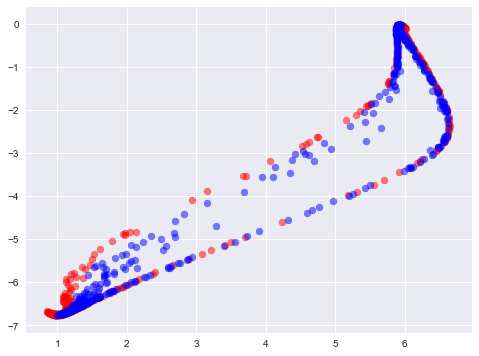

In [97]:
learning_rate = 0.0000008; beta1=0.9; beta2=0.999; adam_e = 1e-8 

l1 = PCA_layer(2,8);  l1b= batch_norm()
l2 = PCA_layer(8,3);  l2b= batch_norm()
l3 = PCA_layer(3,2)

mini_batch_size    = 20
training_iteration = 100

copyX = np.copy(X)
for iter in range(training_iteration):

    copyX = shuffle(copyX)
    for current_batch_index in range(0,len(X),mini_batch_size):
        current_batch = copyX[current_batch_index:current_batch_index+mini_batch_size]
        
        layer1,layer1_var = l1.feed_non(current_batch)
        layer2,layer2_var = l2.feed_non(layer1)
        layer3,layer3_var = l3.feed_linear(layer2)

        sys.stdout.write("Iter: " + str(iter) + " " + str(layer1_var.mean() + layer2_var.mean() + layer3_var.mean()) + '\r'); sys.stdout.flush()
        
        grad3   = l3.back_linear()
        grad2   = l2.back_non(grad3,sign_value=-1)
        grad1   = l1.back_non(grad2,sign_value=-1)
   
layer1,layer1_var = l1.feed_non(X,0)
layer2,layer2_var = l2.feed_non(layer1,0)
layer3,layer3_var = l3.feed_linear(layer2)

trace1 = go.Scatter3d(
    x=layer2[y==0,0],
    y=layer2[y==0,1],
    z=layer2[y==0,2],
    mode='markers',
    line=dict(color='red',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
trace2 = go.Scatter3d(
    x=layer2[y==1,0],
    y=layer2[y==1,1],
    z=layer2[y==1,2],
    mode='markers',
    line=dict(color='blue',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
data = [trace1,trace2]
fig  = go.Figure(data=data)
iplot(fig)

plt.figure(figsize=(8,6))
plt.scatter(layer3[y==0, 0], layer3[y==0, 1], color='red', alpha=0.5)
plt.scatter(layer3[y==1, 0], layer3[y==1, 1], color='blue', alpha=0.5)
plt.show()